# Clustering the 20NewsGroup dataset

### Author: Stephen W. Thomas, Queen's University

### Steps

- Load data (from the scikit-learn package)
- Select subset of data
- Preprocess data
- Transform data into a term document matrix (TDM)
- Apply TF-IDF to TDM
- Run K-Means clustering on TDM
- Measure effectiveness
- Output results and examples

In [1]:
from __future__ import print_function

%matplotlib inline

import os
import re
import sys

import nltk.corpus
import nltk.stem
import numpy as np
from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.spatial.distance import cdist, pdist
import textwrap
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm

/Users/stepthom/anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


# Load Data

In [2]:
# For now, we'll just use these categories
categories = ['rec.sport.baseball', 'talk.religion.misc', 'comp.graphics','sci.space']
data = fetch_20newsgroups(subset='all', categories=categories, shuffle=False)

# Print some metrics about the data
print("Number of docs: %d:" % len(data.data))
print("Number of categories: %d" % len(data.target_names))
i = 0
for cat in range(len(data.target_names)):
    cat_name = data.target_names[cat]
    num_docs = len([d for d in data.target if d == i])
    print("Category %d (%s): %d docs" % (i, cat_name, num_docs))
    i += 1

num_categories = np.unique(categories).shape[0]

Number of docs: 3582:
Number of categories: 4
Category 0 (comp.graphics): 973 docs
Category 1 (rec.sport.baseball): 994 docs
Category 2 (sci.space): 987 docs
Category 3 (talk.religion.misc): 628 docs


# Preprocessing

In [3]:
# Define a new member, .pre, to hold the preprocessed version.
data.pre = []

# A list of custom stopwords to remove
stopwords = set(nltk.corpus.stopwords.words('english'))
stopwords.update(
    ['would', 'subject', 're', 'don', 'jan',
     'feb', 'mar', 'apr', 'may', 'june',
     'july', 'aug', 'sep', 'oct', 'nov', 'dec'])

# Regex pattern for email addresses
email_pattern = re.compile(r'[^@]+@[^@]+\.[^@]+', re.IGNORECASE & re.UNICODE)

# Regex pattern for things found at the top "header" part of the message
header_pattern = re.compile(
    r'^summary:|^x-newsreader:.*|^date:.*'
    r'|^disclaimer:.*|^distribution:.*|^organization:.*'
    r'|^nntp-posting-host:.*|^keywords:.*|^to:.*'
    r'|^in-reply-to:.*|^x-news-reader:.*|^lines:.*',
    re.IGNORECASE & re.UNICODE)

# Regex pattern for general special characters
#special_char_pattern = re.compile(r'[\|=-\[\]\'\":;,\.\<\>\\\/\?_\(\)!$%^&*,]', re.IGNORECASE & re.UNICODE)
special_char_pattern = re.compile(r"[^\w']|_")

# Regex pattern for whole-word numbers
number_pattern = re.compile(r'\b\d+\b')

# Regex pattern to handle strings like the following:
# In article <me@me.com> me@me.com (Me) writes:
writes_pattern = re.compile(r'^.*writes:$')

# Loop through data do the preprocessing
for j in range(0, len(data.data)):
    lines = data.data[j].lower().split("\n")
    for i in range(0, len(lines)):

        # Use the regexes above to remove bad things
        lines[i] = header_pattern.sub(' ', lines[i])
        lines[i] = email_pattern.sub(' ', lines[i])
        lines[i] = number_pattern.sub(' ', lines[i])
        lines[i] = writes_pattern.sub(' ', lines[i])
        lines[i] = special_char_pattern.sub(' ', lines[i])

        # Remove short words
        lines[i] = ' '.join([w for w in lines[i].split() if len(w) > 2])

        # Remove stopwords
        lines[i] = ' '.join([w for w in lines[i].split() if w not in stopwords])

        # Stem the words
        lines[i] = ' '.join([nltk.stem.snowball.SnowballStemmer("english").stem(w) for w in lines[i].split()])

        # Remove extra spaces, just for beauty
        lines[i] = re.sub(r'\s\s+', " ", lines[i])

    pre = " ".join(lines)
    data.pre.append(pre)

# Inspect some of the data

In [12]:
print(data.pre[0])
print("")
print(data.pre[1])

# Which doc is our example in the slides?
for j in range(0, len(data.data)):
    lines = data.data[j].lower().split("\n")
    for i in range(0, len(lines)):
        if "a few years ago a friend and i took" in lines[i]:
            print("{}: {}".format(j, lines[i]))
            
print("")
print(data.pre[1129])
            
print("")
print(data.pre[482])

 cub behind marlin articl agat 1pt592 f9a        morgan guzman era run higher last year cub idiot pitch harkey much hibbard castillo won't good think he stud pitcher  season far morgan guzman help lead cub top era even better rotat atlanta cub era brave know earli season cub fan learn enjoy short triumph still 

 time best player origin news nimast         articl 1993apr13 write  i'v recent work project determin greatest player respect postion  career  johnni hodapp greatest 2nd baseman cleveland indian histori hit consist great great second baseman  header said career hodapp manag nine year major  consist make three year row preced part time year plus last year boston hodapp qualifi bat titl five time  injur retir right around 28th birthday  anyway hodapp put flashi number year everybodi put flashi number realli good year bat year mar lack power inabl draw walk base ball describ fear hitter  hand part long line famous cleveland wambsganss rigg stephenson etc  roger  jon johnni hodapp 

In [254]:
# Look at some of the most frequent words
tokens = []
for pre in data.pre:
    [tokens.append(w) for w in pre.split()]
print("Total terms: {}".format(len(tokens)))
num_unique_terms = len(set(tokens))
print("Unique terms: {}".format(num_unique_terms))
text = nltk.Text(tokens)
fdist1 = nltk.probability.FreqDist(text)
print("Term frequencies:")
for w in fdist1.most_common(100):
    print("{:>6}, {}".format(w[1], w[0].encode("utf-8")))

Total terms: 476206
Unique terms: 23675
Term frequencies:
  2689, one
  2417, use
  2225, imag
  2039, space
  2030, like
  1841, get
  1795, year
  1736, don't
  1694, know
  1661, time
  1608, think
  1566, also
  1404, say
  1316, file
  1315, see
  1314, make
  1303, good
  1288, peopl
  1234, look
  1207, game
  1193, graphic
  1188, program
  1185, system
  1179, it
  1160, could
  1160, first
  1144, god
  1124, well
  1063, point
  1051, even
  1046, much
  1031, run
  1026, want
  1015, way
  1008, work
  1000, i'm
   993, need
   986, thing
   970, two
   949, mani
   937, new
   896, data
   861, bit
   850, post
   837, base
   829, last
   828, jpeg
   820, team
   819, orbit
   817, call
   814, better
   811, softwar
   810, read
   801, come
   800, christian
   800, right
   781, format
   778, find
   776, day
   768, take
   764, avail
   751, anyon
   748, mean
   748, edu
   741, tri
   714, includ
   712, give
   711, back
   709, hit
   707, help
   704, player
 

# Build the TDM Matrix

In [255]:
vectorizer = TfidfVectorizer(max_df=0.6, max_features=10000,
                             min_df=2, stop_words='english',
                             use_idf=True)
tdm = vectorizer.fit_transform(data.pre)

# Get the vocabulary (i.e., terms mapped to their indices)
vocab = vectorizer.vocabulary_

# Inverse the vocabulary (i.e., indices mapped to terms)
ivocab = {}
for term, index in vocab.iteritems():
    ivocab[index] = term

# Run the clustering algorithm

In [256]:
# Try a few different values of K; we'll decide later what's the best.
K = range(1,20)
fits = [KMeans(n_clusters=k, init='k-means++', max_iter=500, n_init=30, verbose=False, random_state=1234).fit(tdm) for k in K]
centroids = [fit.cluster_centers_ for fit in fits]
inertias = [fit.inertia_ for fit in fits]

# Evaluate and Inspect Clusters

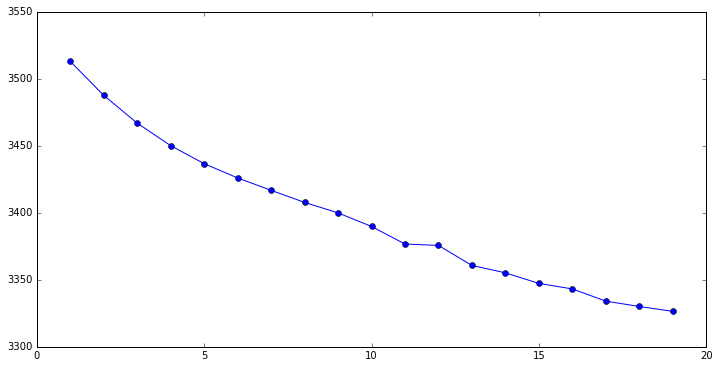

In [257]:
clusters_df = pd.DataFrame( { "num_clusters":K, "cluster_errors": inertias } )
plt.figure(figsize=(12,6))
plt.plot( clusters_df.num_clusters, clusters_df.cluster_errors, marker = "o" )
plt.show()

I was hoping to see a elbow in the curve, but it looks like the metric just gets lower and lower as the number of clusters increases. 

### Examine Top Cluster Terms

For no real good reason, let's select `k=10` and examine some of the resulting clusters.

First, let's print out the top words/terms in each cluster. This will help us to remember them better.

In [258]:
# The top terms for each cluster

k = 10 # Let's select k = 10, just for fun.
km = fits[k]
data.assigned_cluster = km.labels_

cluster_terms = []
order_centroids = km.cluster_centers_.argsort()[:, ::-1]
terms = vectorizer.get_feature_names()
for i in range(k):
    print("Cluster {:>2} ({:>4} docs):".format(i, len([x for x in km.labels_ if x == i])), end='')
    cterms = []
    for ind in order_centroids[i, :9]:
        print(' {}'.format(terms[ind]), end='')
        cterms.append(terms[ind])
    cluster_terms.append(' '.join(cterms))
    print("")

Cluster  0 ( 163 docs): file format gif convert cview program ftp graphic pov
Cluster  1 (  71 docs): moral object valu say christian kuiper smiley subject peopl
Cluster  2 ( 323 docs): game team win pitch run score brave pitcher basebal
Cluster  3 (1131 docs): like know think don time peopl new say right
Cluster  4 ( 646 docs): graphic thank mail pleas look use program polygon help
Cluster  5 ( 194 docs): orbit mission hst solar shuttl satellit spacecraft comet jupit
Cluster  6 ( 277 docs): hit year player bat hitter ball defens good play
Cluster  7 (  37 docs): jewish player basebal lowenstein come hank koufax stankowitz sandi
Cluster  8 ( 216 docs): god christian jesus bibl christ believ peopl love law
Cluster  9 ( 392 docs): space moon launch nasa cost station shuttl billion sky


### "Confusion Matrix"

Since we have the "truth" categories from which each document came, we can build a "confusion-matrix"-like table that shows, for each cluster, which categories the assigned documents came from.

In [259]:
# Rows are the actual categories, colums are the assigned clusters
print("Confusion matrix:\n")
cmat = metrics.confusion_matrix(y_true=data.target, y_pred=km.labels_)
print(cmat[0:num_categories, 0:k])
print("\nRows:")
for i, name in enumerate(data.target_names):
    print(" {}: {}".format(i, name))
print("\nColumns:")
for i, terms in enumerate(cluster_terms):
    print(" {}: {}".format(i, terms))

Confusion matrix:

[[161   3   0 120 572   0   0   0   0   1]
 [  2   0 323 320  35   0 277  37   0   0]
 [  0   9   0 343  34 194   0   0   0 391]
 [  0  59   0 348   5   0   0   0 216   0]]

Rows:
 0: comp.graphics
 1: rec.sport.baseball
 2: sci.space
 3: talk.religion.misc

Columns:
 0: file format gif convert cview program ftp graphic pov
 1: moral object valu say christian kuiper smiley subject peopl
 2: game team win pitch run score brave pitcher basebal
 3: like know think don time peopl new say right
 4: graphic thank mail pleas look use program polygon help
 5: orbit mission hst solar shuttl satellit spacecraft comet jupit
 6: hit year player bat hitter ball defens good play
 7: jewish player basebal lowenstein come hank koufax stankowitz sandi
 8: god christian jesus bibl christ believ peopl love law
 9: space moon launch nasa cost station shuttl billion sky


Pretty neat! 

### Look at some examples

In [260]:
def printDoc(j, data, km, cluster_terms):
    '''
    Given a document ID, print everything we know about it.
    '''
    print("Document ID: {}".format(j))
    print("Filename: {}".format(os.path.basename(data.filenames[j])))
    print("Truth category: {} ({})".format(data.target[j], data.target_names[data.target[j]]))
    print("Assigned cluster: {} ({})".format(km.labels_[j], cluster_terms[km.labels_[j]]))
    print("Raw data:")
    print("============ START RAW ==========================\n")
    print(data.data[j].encode("utf-8"))
    print("\n========== END RAW ============================")
    lines = textwrap.wrap(data.pre[j].encode("utf-8"), 50)
    print("\nPreprocessed:\n")
    print("============ START PREPROCESSED =================\n")
    for line in lines:
        print(line)
    print("========== END PREPROCESSED =====================\n")
    print("\nFeature vector (Top 15, sorted, non-zero values only):")
    print("Term, Index, Value:")

    Xa = tdm.toarray()[j]
    sorted_ind = sorted(range(len(Xa)), key=lambda k: Xa[k])
    for i, ind in enumerate(reversed(sorted_ind)):
        if (i > 15): # Only print top terms
            break
        val = Xa[ind]
        if val > 0:
            print(("{:>20s}, {:>5d}, {:>6.3f}".format(ivocab[ind], ind, val)))
    

#### Cluster 0

In [261]:
idx_0 = [i for i, j in enumerate(km.labels_) if j == 0]
printDoc(idx_0[0], data, km, cluster_terms)
printDoc(idx_0[1], data, km, cluster_terms)
printDoc(idx_0[2], data, km, cluster_terms)

Document ID: 21
Filename: 38760
Truth category: 0 (comp.graphics)
Assigned cluster: 0 (file format gif convert cview program ftp graphic pov)
Raw data:
============ START RAW ==========================

From: stusoft@hardy.u.washington.edu (Stuart Denman)
Subject: Re: 3D2 files - what are they?
Article-I.D.: shelley.1rft1nINNc7s
Organization: University of Washington
Lines: 16
NNTP-Posting-Host: hardy.u.washington.edu

doug@hparc0.aus.hp.com (Doug Parsons) writes:

>I was chaining around in the anonymous ftp world looking for 3D Studio
>meshes and other interesting graphical stuff for the program, and found
>a few files with the extension 3D2.  My 3DS v2.01 doesn't know this type
>of file, so what are they?

They are 3D object files for CAD 3D 2.0, a program written by Tom Hudson
for the Atari ST computers.  Don't know much more about them except that
they are stored with the points first, then the surfaces are next, and are
made by listing 3 point numbers that make up the triangle sur

#### Cluster 1

In [262]:
idx_1 = [i for i, j in enumerate(km.labels_) if j == 1]
printDoc(idx_1[0], data, km, cluster_terms)
printDoc(idx_1[1], data, km, cluster_terms)
printDoc(idx_1[2], data, km, cluster_terms)

Document ID: 9
Filename: 84309
Truth category: 3 (talk.religion.misc)
Assigned cluster: 1 (moral object valu say christian kuiper smiley subject peopl)
Raw data:
============ START RAW ==========================

From: markp@elvis.wri.com (Mark Pundurs)
Subject: Re: After 2000 years, can we say that Christian Morality is
Nntp-Posting-Host: elvis.wri.com
Organization: Wolfram Research, Inc.
Lines: 27

In <930415.112243.8v6.rusnews.w165w@mantis.co.uk> mathew@mantis.co.uk (mathew) writes:

>There's no objective physics; Einstein and Bohr have told us that.

Speaking as one who knows relativity and quantum mechanics, I say: 
Bullshit.

>There's no objective reality.  LSD should be sufficient to prove that.

Speaking as one who has taken LSD, I say: 
Bullshit.

>> One wonders just what people who ask such questions understand by the term 
>> "objective", if anything.

>I consider it to be a useful fiction; an abstract ideal we can strive
>towards.  Like an ideal gas or a light inextensible 

#### Cluster 2

In [263]:
idx_2 = [i for i, j in enumerate(km.labels_) if j == 2]
printDoc(idx_2[0], data, km, cluster_terms)
printDoc(idx_2[1], data, km, cluster_terms)
printDoc(idx_2[2], data, km, cluster_terms)

Document ID: 0
Filename: 102736
Truth category: 1 (rec.sport.baseball)
Assigned cluster: 2 (game team win pitch run score brave pitcher basebal)
Raw data:
============ START RAW ==========================

From: cubbie@garnet.berkeley.edu (                               )
Subject: Re: Cubs behind Marlins? How?
Article-I.D.: agate.1pt592$f9a
Organization: University of California, Berkeley
Lines: 12
NNTP-Posting-Host: garnet.berkeley.edu


gajarsky@pilot.njin.net writes:

morgan and guzman will have era's 1 run higher than last year, and
 the cubs will be idiots and not pitch harkey as much as hibbard.
 castillo won't be good (i think he's a stud pitcher)

       This season so far, Morgan and Guzman helped to lead the Cubs
       at top in ERA, even better than THE rotation at Atlanta.
       Cubs ERA at 0.056 while Braves at 0.059. We know it is early
       in the season, we Cubs fans have learned how to enjoy the
       short triumph while it is still there.


========== END RAW ===

#### Cluster 3
This just looks like a general, unspecific cluster.

In [264]:
idx_3 = [i for i, j in enumerate(km.labels_) if j == 3]
printDoc(idx_3[0], data, km, cluster_terms)
printDoc(idx_3[1], data, km, cluster_terms)
printDoc(idx_3[2], data, km, cluster_terms)

Document ID: 3
Filename: 38263
Truth category: 0 (comp.graphics)
Assigned cluster: 3 (like know think don time peopl new say right)
Raw data:
============ START RAW ==========================

From: davidr@rincon.ema.rockwell.com (David J. Ray)
Subject: Re: Fractals? what good are they?
Organization: Rockwell International
X-Newsreader: Tin 1.1 PL5
Lines: 16

In regards to fractal commpression, I have seen 2 fractal compressed "movies".
They were both fairly impressive.  The first one was a 64 gray scale "movie" of
Casablanca, it was 1.3MB and had 11 minutes of 13 fps video.  It was a little
grainy but not bad at all.  The second one I saw was only 3 minutes but it
had 8 bit color with 10fps and measured in at 1.2MB.

I consider the fractal movies a practical thing to explore.  But unlike many 
other formats out there, you do end up losing resolution.  I don't know what
kind of software/hardware was used for creating the "movies" I saw but the guy
that showed them to me said it took 5-

#### Cluster 7
This looks like something to do with Jewish baseball players.

In [265]:
idx_7 = [i for i, j in enumerate(km.labels_) if j == 7]
printDoc(idx_7[0], data, km, cluster_terms)
printDoc(idx_7[1], data, km, cluster_terms)
printDoc(idx_7[2], data, km, cluster_terms)

Document ID: 22
Filename: 104933
Truth category: 1 (rec.sport.baseball)
Assigned cluster: 7 (jewish player basebal lowenstein come hank koufax stankowitz sandi)
Raw data:
============ START RAW ==========================

From: roger@crux.Princeton.EDU (Roger Lustig)
Subject: Re: Jewish Baseball Players?
Originator: news@nimaster
Nntp-Posting-Host: crux.princeton.edu
Reply-To: roger@astro.princeton.edu (Roger Lustig)
Organization: Princeton University
Lines: 24

In article <15APR93.14691229.0062@lafibm.lafayette.edu> VB30@lafibm.lafayette.edu (VB30) writes:
>Just wondering.  A friend and I were talking the other day, and
>we were (for some reason) trying to come up with names of Jewish
>baseball players, past and present.  We weren't able to come up
>with much, except for Sandy Koufax, (somebody) Stankowitz, and
>maybe John Lowenstein.  Can anyone come up with any more.  I know
>it sounds pretty lame to be racking our brains over this, but
>humor us.  Thanks for your help.

Stankiewicz

In [266]:
printDoc(999, data, km, cluster_terms)

Document ID: 999
Filename: 61027
Truth category: 2 (sci.space)
Assigned cluster: 4 (graphic thank mail pleas look use program polygon help)
Raw data:
============ START RAW ==========================

From: wallacen@CS.ColoState.EDU (nathan wallace)
Subject:  Level 5
Reply-To: wallacen@CS.ColoState.EDU
Nntp-Posting-Host: sor.cs.colostate.edu
Organization: Colorado State University -=- Computer Science Dept.
Lines: 15

According to a Software engineering professor here, what was actually rated
level five was an ibm unit which produced part of the software for the shuttle,
by not means all of it. 

Interesting note: 90% of the software development groups surveyed were at
level 1. The ibm shuttle groups was the *only* one at level 5!

---
C/C/C/C/C/C/C/C/C/C/C/C/C/C/C/C/C/C/C/C/C/C/C/C/C/C/C/C/C/C/C/C/C/C/C/C/C/C/C/C/
C/    Nathan F. Wallace                   C/C/           "Reality Is"         C/
C/    e-mail: wallacen@cs.colostate.edu   C/C/    ancient Alphaean proverb    C/
C/C/C/C/C/C

### Look at Some Mismatches/Errors

Since we conveniently have the truth categories that each document came from, we can (sort of) look at some documents that were not assigned to an expected cluster, by looking at the confusion matrix above. For example, if a given category had 99% of its documents assigned to cluster 3, then we can look at the 1% that weren't assigned to cluster three to see what the problem is. Likewise, if a given cluster contains documents mostly from category 1, then we can look at some of the documents in the cluster that didn't come from category 1.


First, we'll define a quick function to do the work.

In [267]:
def findMismatches(target_id, label_id, data):
    '''
    Given a truth category (i.e., target_id) and an assigned clusters id (i.e., label_id), find
    document_ids that match the label_id but *not* the target_id. 
    '''
    mismatches = []
    for i in range(0, len(data.pre)):
        if (data.target[i] != target_id and data.assigned_cluster[i] == label_id):
            mismatches.append(i)
    return mismatches

#### Cluster 0/Category 0

Looking at the confusion matrix above, it looks like most documents assigned to cluster 0 ("file format gif convert cview program") come from category 0 (comp.graphics). Let's look at documents assigned to cluster 0 that aren't from category 0.

In [268]:
m = findMismatches(0, 0, data)
m
print("")
printDoc(m[0], data, km, cluster_terms)
print("")
printDoc(m[1], data, km, cluster_terms)


Document ID: 2519
Filename: 104886
Truth category: 1 (rec.sport.baseball)
Assigned cluster: 0 (file format gif convert cview program ftp graphic pov)
Raw data:
============ START RAW ==========================

From: cruz@stsci.edu
Subject: Re: Baseball logos available via anonymous FTP
Lines: 31
Organization: Space Telescope Science Institute
Distribution: world,na

In article <1993Apr21.165206.13060@ac.dal.ca>, arishem@ac.dal.ca writes:
> 
> Well, thanks to Matthew Wall, the Major League baseball logos which I've been
> posting over the past number of weeks now have a home at the Internet
> Baseball Archive.
> To get them, FTP to eucalyptus.cc.swarthmore.edu, login anonymously as per
> usual, and cd to the baseball/misc/graphics directory.  Both the GIF files
> and the uuencoded versions are available.
> 
>   Darren
> 
>  Darren Reiniger                   reiniger@ug.cs.dal.ca || arishem@ac.dal.ca
>  Centre For Marine Geology, Dalhousie University, Halifax, N.S., Canada
> | People w

#### Cluster 9/Category 2

Now, let's look at the single document that was assigned to cluster 9 (space moon launch nasa cost station shuttl billion sky like) and didn't come from category 2 (sci.space).

In [269]:
m = findMismatches(2, 9, data)
m
print("")
printDoc(m[0], data, km, cluster_terms)


Document ID: 2801
Filename: 39496
Truth category: 0 (comp.graphics)
Assigned cluster: 9 (space moon launch nasa cost station shuttl billion sky)
Raw data:
============ START RAW ==========================

From: wnkretz@ikesg1.energietechnik.uni-stuttgart.de (Oliver Kretzschmar)
Subject: Need C-algorithm, which decide whether a 3D-point is inside a space, defined by 6 planes
Organization: IKE
Lines: 31
Distribution: world
NNTP-Posting-Host: ikesg1.energietechnik.uni-stuttgart.de




   Hey,

   I am looking for C-algorithm, which decide,whether a 3D-Point is
   inside a space which was defined by 8 x 3D-points.
   With a space defined by 8 x 3D-points, I mean a space defined by
   6 closed 3D meshes defined by 8 points. Like this :

              _____
             /    /|
            /____/ |
            |    | |
            |    | /
            |____|/


   But in this simple example, the sides are parallel, but my problem,
   the sides can be non parallel and the opposite sides mus

#### Cluster 1/Category 3

Now, one more Let's look at cluster 1 (moral object valu say christian kuiper smiley subject peopl atom), where most docs came from category 3 (talk.religion.misc).

In [270]:
m = findMismatches(3, 1, data)
m
print("")
printDoc(m[0], data, km, cluster_terms)
printDoc(m[1], data, km, cluster_terms)
printDoc(m[3], data, km, cluster_terms)


Document ID: 61
Filename: 61067
Truth category: 2 (sci.space)
Assigned cluster: 1 (moral object valu say christian kuiper smiley subject peopl)
Raw data:
============ START RAW ==========================

From: chico@ccsun.unicamp.br (Francisco da Fonseca Rodrigues)
Subject: New planet/Kuiper object found?
X-Added: Forwarded by Space Digest
Organization: [via International Space University]
Original-Sender: isu@VACATION.VENARI.CS.CMU.EDU
Distribution: sci
Lines: 28


	Tonigth a TV journal here in Brasil announced that an object,
beyond Pluto's orbit, was found by an observatory at Hawaii. They
named the object Karla.

	The program said the object wasn't a gaseous giant planet, and
should be composed by rocks and ices.

	Can someone confirm these information? Could this object be a
new planet or a Kuiper object?

	Thanks in advance.

	Francisco.

-----------------------=====================================----the stars,----
|    ._,               | Francisco da Fonseca Rodrigues    |  